<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow/Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to TensorFlow 2

In [1]:
import numpy as np
import pandas as pd
from sklearn import model_selection
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")
import time
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
x = {
    "type": [0, 1, 1],
    "size": ["small", "small", "medium"],
    "weight": [2.7, 1.8, 1.6]
}

inputs = {
    "type": tf.keras.Input(shape=(), dtype=tf.int64),
    "size": tf.keras.Input(shape=(), dtype=tf.string),
    "weight": tf.keras.Input(shape=(), dtype=tf.float32)
}

type_output = tf.keras.layers.CategoryEncoding(
    num_tokens=3, output_mode="one_hot")(inputs["type"])
size_output = tf.keras.layers.StringLookup(
    vocabulary=["small", "medium", "large"])(inputs["size"])
weight_output = tf.keras.layers.Normalization(axis=None,
    mean=2.0, variance=1.0)(inputs["weight"])

outputs = {
    "type": type_output,
    "size": size_output,
    "weight": weight_output
}

preprosessing_model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [2]:
dataset_url = "http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip"
csv_file = "datasets/petfinder-mini/petfinder-mini.csv"

tf.keras.utils.get_file(fname="petfinder_mini.zip", origin=dataset_url, extract=True,
    cache_dir=".")
df = pd.read_csv(csv_file)
df["label"] = np.where(df["AdoptionSpeed"]==4, 0, 1)
df.drop(inplace=True, columns=["Description", "AdoptionSpeed"])
df.info()
df.head()

1668792/1668792 [==============================] - 1s 1us/step
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11537 entries, 0 to 11536
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Type          11537 non-null  object
 1   Age           11537 non-null  int64 
 2   Breed1        11537 non-null  object
 3   Gender        11537 non-null  object
 4   Color1        11537 non-null  object
 5   Color2        11537 non-null  object
 6   MaturitySize  11537 non-null  object
 7   FurLength     11537 non-null  object
 8   Vaccinated    11537 non-null  object
 9   Sterilized    11537 non-null  object
 10  Health        11537 non-null  object
 11  Fee           11537 non-null  int64 
 12  PhotoAmt      11537 non-null  int64 
 13  label         11537 non-null  int64 
dtypes: int64(4), object(10)
memory usage: 1.2+ MB


,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,label
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,1,1
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,2,1
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,7,1
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,8,1
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,3,1


In [ ]:
def df_to_ds(dataframe, batch_size, shuffle=False):
    df = dataframe.copy()
    y = df.pop("label")
    x = {k: v.values[:, tf.newaxis] for k, v in df.items()}
    ds = tf.data.Dataset.from_tensor_slices(tensors=(x, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size=batch_size)
    ds = ds.prefetch(buffer_size=batch_size)
    return ds

df_train, df_test = model_selection.train_test_split(
    df, test_size=0.1, random_state=42)

ds_train = df_to_ds(dataframe=df_train, batch_size=256, shuffle=True)
ds_test = df_to_ds(dataframe=df_test, batch_size=32)
ds_test.element_spec

({'Type': TensorSpec(shape=(None, 1), dtype=tf.string, name=None),
  'Age': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None),
  'Breed1': TensorSpec(shape=(None, 1), dtype=tf.string, name=None),
  'Gender': TensorSpec(shape=(None, 1), dtype=tf.string, name=None),
  'Color1': TensorSpec(shape=(None, 1), dtype=tf.string, name=None),
  'Color2': TensorSpec(shape=(None, 1), dtype=tf.string, name=None),
  'MaturitySize': TensorSpec(shape=(None, 1), dtype=tf.string, name=None),
  'FurLength': TensorSpec(shape=(None, 1), dtype=tf.string, name=None),
  'Vaccinated': TensorSpec(shape=(None, 1), dtype=tf.string, name=None),
  'Sterilized': TensorSpec(shape=(None, 1), dtype=tf.string, name=None),
  'Health': TensorSpec(shape=(None, 1), dtype=tf.string, name=None),
  'Fee': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None),
  'PhotoAmt': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)},
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [ ]:
inputs = []
features = []

for h in ["Fee", "PhotoAmt"]:
    col = tf.keras.Input(shape=(), name=h, dtype=tf.int64)
    inputs.append(col)
    x = ds_train.map(map_func=lambda x, y: x[h])
    normalizer = tf.keras.layers.Normalization(axis=None)
    normalizer.adapt(x)
    feature = normalizer(col)
    features.append(feature)

for h in ["Type", "Breed1", "Gender", "Color1", "Color2", "MaturitySize", "FurLength",
        "Vaccinated", "Sterilized", "Health"]:
    col = tf.keras.Input(shape=(), name=h, dtype=tf.string)
    inputs.append(col)
    x = ds_train.map(map_func=lambda x, y: x[h])
    index = tf.keras.layers.StringLookup(max_tokens=5)
    index.adapt(x)
    feature = tf.keras.layers.CategoryEncoding(
        num_tokens=index.vocabulary_size())
    features.append(feature)

for h in ["Age"]:
    col = tf.keras.Input(shape=(), name=h, dtype=tf.int64)
    inputs.append(col)
    x = ds_train.map(map_func=lambda x, y: x[h])
    index = tf.keras.layers.IntegerLookup(max_tokens=5)
    index.adapt(x)
    feature = tf.keras.layers.CategoryEncoding(
        num_tokens=index.vocabulary_size())
    features.append(feature)

In [ ]:
outputs = tf.keras.layers.concatenate(features)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

ValueError: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: <CategoryEncoding name=category_encoding, built=False> (of type <class 'keras.src.layers.preprocessing.category_encoding.CategoryEncoding'>)

### UCI Bank Marketing Dataset

The `Bank Marketing` dataset is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. [here](https://archive.ics.uci.edu/dataset/222/bank+marketing).

In [ ]:
df_bank = pd.read_csv("data/bank/bank-full.csv", delimiter=";")
df_bank.info()
df_bank.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,other,no


In [ ]:
ds_bank = tf.data.Dataset.from_tensor_slices(tensors=dict(df_bank))
ds_bank.element_spec

{'age': TensorSpec(shape=(), dtype=tf.int64, name=None),
 'job': TensorSpec(shape=(), dtype=tf.string, name=None),
 'marital': TensorSpec(shape=(), dtype=tf.string, name=None),
 'education': TensorSpec(shape=(), dtype=tf.string, name=None),
 'default': TensorSpec(shape=(), dtype=tf.string, name=None),
 'balance': TensorSpec(shape=(), dtype=tf.int64, name=None),
 'housing': TensorSpec(shape=(), dtype=tf.string, name=None),
 'loan': TensorSpec(shape=(), dtype=tf.string, name=None),
 'contact': TensorSpec(shape=(), dtype=tf.string, name=None),
 'day': TensorSpec(shape=(), dtype=tf.int64, name=None),
 'month': TensorSpec(shape=(), dtype=tf.string, name=None),
 'duration': TensorSpec(shape=(), dtype=tf.int64, name=None),
 'campaign': TensorSpec(shape=(), dtype=tf.int64, name=None),
 'pdays': TensorSpec(shape=(), dtype=tf.int64, name=None),
 'previous': TensorSpec(shape=(), dtype=tf.int64, name=None),
 'poutcome': TensorSpec(shape=(), dtype=tf.string, name=None),
 'y': TensorSpec(shape=(), d

In [ ]:
inputs = {
    'age': tf.keras.Input(shape=(1,), dtype=tf.int64, name='age')
}

age = tf.keras.layers.Discretization(
    bin_boundaries=[10, 20, 30, 40, 50, 60, 70, 80, 90])(inputs['age'])
age = tf.keras.layers.CategoryEncoding(num_tokens=10, output_mode='one_hot')(age)

outputs = {
    'age': age
}

preprocessing_model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
ds01 = ds_bank.batch(1)
ds01 = ds01.map(lambda x: preprocessing_model(x))
next(iter(ds01))

{'age': <tf.Tensor: shape=(1, 1, 10), dtype=float32, numpy=array([[[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]]], dtype=float32)>}

In [ ]:
df_train, df_test = model_selection.train_test_split(
    df_bank, test_size=0.1, random_state=42)

dict_train = dict(df_train)
ds_train = tf.data.Dataset.from_tensor_slices(tensors={
    k: dict_train[k] for k in dict_train})

dict_test = dict(df_test)
ds_test = tf.data.Dataset.from_tensor_slices(tensors={
    k: dict_test[k] for k in dict_test})
ds_test.element_spec

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

batch_size = 64

ds_train = tf.data.Dataset.from_tensor_slices(tensors=(x_train, y_train))
ds_train = ds_train.map(map_func=lambda x, y: (
    tf.cast(x=x, dtype=tf.float32)/255., y))
ds_train = ds_train.map(map_func=lambda x, y: (
    tf.reshape(x, (784,)), y))
ds_train = ds_train.shuffle(buffer_size=len(ds_train))\
    .batch(batch_size=batch_size)

ds_test = tf.data.Dataset.from_tensor_slices(tensors=(x_test, y_test))
ds_test = ds_test.map(map_func=lambda x, y:
    (tf.cast(x=x, dtype=tf.float32)/255., y))
ds_test = ds_test.map(map_func=lambda x, y: (
    tf.reshape(x, (784,)), y))
ds_test = ds_test.batch(batch_size=batch_size)
print("Element spec:", ds_test.element_spec)

Element spec: (TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))


In [ ]:
def get_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    h = tf.keras.layers.Dense(units=64,
        activation=tf.keras.activations.relu,
        kernel_regularizer=tf.keras.regularizers.L2(l2=1e-5))(inputs)
    h = tf.keras.layers.Dropout(rate=0.2)(h)
    outputs = tf.keras.layers.Dense(units=num_classes,
        activation=tf.keras.activations.softmax)(h)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

model = get_model(input_shape=(784,), num_classes=10)
model.summary()

model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
)

@tf.function
def train_step(x, y):
    logs = {}
    with tf.GradientTape() as tape:
        y_pred = model(inputs=x, training=True)
        loss = model.compute_loss(y=y, y_pred=y_pred)

    trainable_vars = model.trainable_variables
    grads = tape.gradient(target=loss,
        sources=trainable_vars)
    model.optimizer.apply_gradients(grads_and_vars=zip(
        grads, trainable_vars))

    for metric in model.metrics:
        if metric.name=="loss":
            metric.update_state(values=loss)
        else:
            metric.update_state(y_true=y, y_pred=y_pred)

    metrics = [m.result() for m in model.metrics]
    logs = {f"train_{k}": v for k, v in metrics[1].items()}
    logs["train_loss"] = metrics[0]

    return logs

@tf.function
def test_step(x, y):
    y_pred = model(inputs=x, training=False)
    loss = model.compute_loss(y=y, y_pred=y_pred)

    for metric in model.metrics:
        if metric.name=="loss":
            metric.update_state(values=loss)
        else:
            metric.update_state(y_true=y, y_pred=y_pred)

    metrics = [m.result() for m in model.metrics]
    logs = {f"test_{k}": v for k, v in metrics[1].items()}
    logs["test_loss"] = metrics[0]

    return logs

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="test_loss",
    patience=1)
callbacks = tf.keras.callbacks.CallbackList(model=model,
    callbacks=[reduce_lr], add_history=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,890 (198.79 KB)

 Trainable params: 50,890 (198.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
num_epochs = 10
start_time = time.time()
history = {
    "train_loss": [], "test_loss": [],
    "train_accuracy": [], "test_accuracy": []
}

logs = {}
callbacks.on_train_begin(logs=logs)

for epoch in range(num_epochs):
    callbacks.on_epoch_begin(epoch=epoch, logs=logs)

    for x, y in ds_train:
        logs = train_step(x, y)
    history["train_loss"].append(logs["train_loss"].numpy())
    history["train_accuracy"].append(logs["train_accuracy"].numpy())

    for x, y in ds_test:
        logs = test_step(x, y)
    history["test_loss"].append(logs["test_loss"].numpy())
    history["test_accuracy"].append(logs["test_accuracy"].numpy())

    callbacks.on_epoch_end(epoch=epoch, logs=logs)

callbacks.on_train_end(logs=logs)
print("Time taken: %.2fs"%(time.time() - start_time))

Time taken: 42.20s


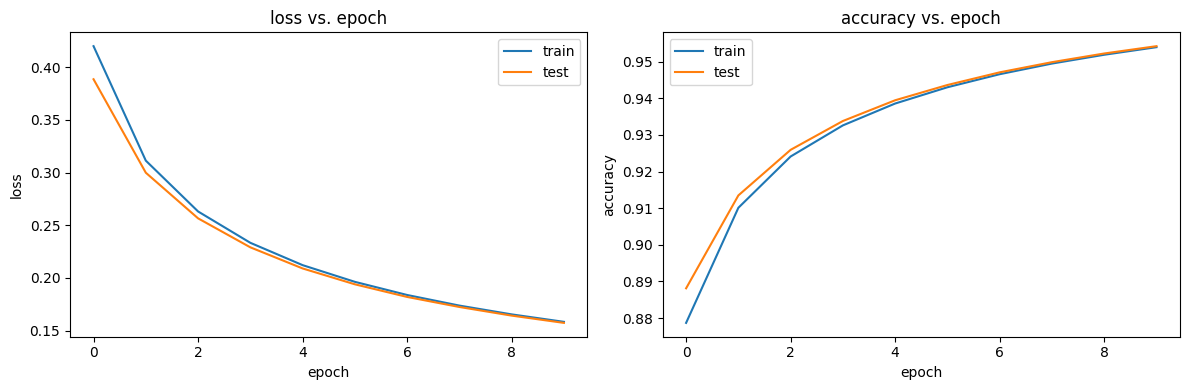

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
for ax, m in zip(axes, ["loss", "accuracy"]):
    for l in ["train", "test"]:
        g = sns.lineplot(ax=ax, label=l, x=range(num_epochs), y=history[f"{l}_{m}"])
    ax.legend(loc="best")
    ax.set_xlabel(xlabel="epoch")
    ax.set_ylabel(ylabel=f"{m}")
    ax.set_title(label=f"{m} vs. epoch")
fig.tight_layout()
plt.show()